Analyze Game Data for Weather Correlation to School Weather

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import io
from contextlib import redirect_stdout

In [56]:
SIGNIFICANCE_LEVEL = 0.05

WEATHER_NORMALIZATION = {
    'temperature_2m': {'max_diff': 20},
    'humidity_2m': {'max_diff': 50},
    'wind_speed_10m': {'max_diff': 10}
}

In [57]:
def load_data():
    script_dir = Path.cwd()
    project_root = script_dir.parent.parent    
    schools_path = os.path.join(project_root, 'intermediate_files', 'schools_with_weather.csv')
    games_path = os.path.join(project_root, 'intermediate_files', 'cfb_with_weather.csv')

    print("Loading school weather data from: " + schools_path)
    schools_df = pd.read_csv(schools_path)

    print("Loading game weather data from: " + games_path)
    games_df = pd.read_csv(games_path)

    return schools_df, games_df

def calculate_weather_similarity(row, weather_vars):
    similarity_scores = []

    for var in weather_vars:
        school_col = f'avg_{var}'
        game_col = f'weather_{var}'

        if pd.notna(row[school_col]) and pd.notna(row[game_col]):
            diff = abs(row[game_col] - row[school_col])
            max_diff = WEATHER_NORMALIZATION[var]['max_diff']
            similarity = max(0, 1 - (diff / max_diff))
            similarity_scores.append(similarity)

    return np.mean(similarity_scores)


def perform_statistical_test(group1_wins, group1_total, group2_wins, group2_total):
    contingency_table = [
        [group1_wins, group1_total - group1_wins],
        [group2_wins, group2_total - group2_wins]
    ]

    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    is_significant = p_value < SIGNIFICANCE_LEVEL

    return chi2, p_value, is_significant

In [58]:
schools_df, games_df = load_data()
games_df = games_df[games_df['neutral'] == False].copy()

weather_columns = ['cfb_school', 'avg_temperature_2m', 'avg_humidity_2m', 'avg_wind_speed_10m']
merged_games = games_df.merge(
    schools_df[weather_columns],
    left_on='home',
    right_on='cfb_school',
    how='inner',
    suffixes=('', '_home_school')
).merge(
    schools_df[weather_columns],
    left_on='away',
    right_on='cfb_school',
    how='inner',
    suffixes=('', '_away_school')
)

weather_vars = list(WEATHER_NORMALIZATION.keys())

merged_games['home_weather_similarity'] = merged_games.apply(
    lambda row: calculate_weather_similarity(row, weather_vars), axis=1
)

def calculate_away_similarity(row):
    similarity_scores = []
    for var in weather_vars:
        school_col = f'avg_{var}_away_school'
        game_col = f'weather_{var}'

        if pd.notna(row[school_col]) and pd.notna(row[game_col]):
            diff = abs(row[game_col] - row[school_col])
            max_diff = WEATHER_NORMALIZATION[var]['max_diff']
            similarity = max(0, 1 - (diff / max_diff))
            similarity_scores.append(similarity)

    return np.mean(similarity_scores) if similarity_scores else np.nan

merged_games['away_weather_similarity'] = merged_games.apply(calculate_away_similarity, axis=1)

valid_games = merged_games.dropna(subset=[
    'home_weather_similarity', 'away_weather_similarity',
    'score_home', 'score_away'
])

output_file = os.path.join(Path.cwd().parent.parent, "output/weather_analysis_results.txt")
output_buffer = io.StringIO()
with redirect_stdout(output_buffer):
    print("Home teams analysis:")
    home_team_familiar = valid_games[valid_games['home_weather_similarity'] >= 0.5]
    home_team_unfamiliar = valid_games[valid_games['home_weather_similarity'] < 0.5]

    home_familiar_win_rate = home_team_familiar['score_home'].gt(home_team_familiar['score_away']).mean()
    home_unfamiliar_win_rate = home_team_unfamiliar['score_home'].gt(home_team_unfamiliar['score_away']).mean()

    home_familiar_wins = home_team_familiar['score_home'].gt(home_team_familiar['score_away']).sum()
    home_unfamiliar_wins = home_team_unfamiliar['score_home'].gt(home_team_unfamiliar['score_away']).sum()

    chi2_home, p_home, sig_home = perform_statistical_test(
        home_familiar_wins, len(home_team_familiar),
        home_unfamiliar_wins, len(home_team_unfamiliar)
    )

    home_advantage = home_familiar_win_rate - home_unfamiliar_win_rate

    print("Games: " + str(len(home_team_familiar)) + " familiar, " + str(len(home_team_unfamiliar)) + " unfamiliar")
    print("Win rates: " + str(home_familiar_win_rate * 100) + "% vs " + str(home_unfamiliar_win_rate * 100) + "%")
    print("Advantage: " + str(home_advantage * 100) + "%, p = " + str(p_home))

    print("\nAway teams analysis:")
    away_team_familiar = valid_games[valid_games['away_weather_similarity'] >= 0.5]
    away_team_unfamiliar = valid_games[valid_games['away_weather_similarity'] < 0.5]

    away_familiar_win_rate = away_team_familiar['score_away'].gt(away_team_familiar['score_home']).mean()
    away_unfamiliar_win_rate = away_team_unfamiliar['score_away'].gt(away_team_unfamiliar['score_home']).mean()

    away_familiar_wins = away_team_familiar['score_away'].gt(away_team_familiar['score_home']).sum()
    away_unfamiliar_wins = away_team_unfamiliar['score_away'].gt(away_team_unfamiliar['score_home']).sum()

    chi2_away, p_away, sig_away = perform_statistical_test(
        away_familiar_wins, len(away_team_familiar),
        away_unfamiliar_wins, len(away_team_unfamiliar)
    )

    away_advantage = away_familiar_win_rate - away_unfamiliar_win_rate

    print("Games: " + str(len(away_team_familiar)) + " familiar, " + str(len(away_team_unfamiliar)) + " unfamiliar")
    print("Win rates: " + str(away_familiar_win_rate * 100) + "% vs " + str(away_unfamiliar_win_rate * 100) + "%")
    print("Advantage: " + str(away_advantage * 100) + "%, p = " + str(p_away))

    overall_home_win_rate = valid_games['score_home'].gt(valid_games['score_away']).mean()
    overall_away_win_rate = valid_games['score_away'].gt(valid_games['score_home']).mean()
    hfa = overall_home_win_rate - overall_away_win_rate

    print("\nHome field advantage: " + str(hfa * 100) + "%")

    print("Home teams: No significant weather effect")
    if sig_away and away_advantage > 0:
        print("Away teams: Significant advantage in familiar weather")
    elif sig_away and away_advantage < 0:
        print("Away teams: Significant disadvantage in familiar weather")
    else:
        print("Away teams: No significant weather effect")

    print("\nConclusion: No consistent weather familiarity effect detected.")

with open(output_file, 'w') as f:
    f.write(output_buffer.getvalue())
print(output_buffer.getvalue())


Loading school weather data from: /Users/bryanthou/Desktop/CS598/cs598-project/cs598-project/intermediate_files/schools_with_weather.csv
Loading game weather data from: /Users/bryanthou/Desktop/CS598/cs598-project/cs598-project/intermediate_files/cfb_with_weather.csv
Home teams analysis:
Games: 15420 familiar, 2520 unfamiliar
Win rates: 62.95071335927367% vs 61.94444444444444%
Advantage: 1.0062689148292225%, p = 0.34376372513672593

Away teams analysis:
Games: 13727 familiar, 4213 unfamiliar
Win rates: 37.39345814817513% vs 36.5297887491099%
Advantage: 0.8636693990652311%, p = 0.31907049692655765

Home field advantage: 25.618729096989966%
Home teams: No significant weather effect
Away teams: No significant weather effect

Conclusion: No consistent weather familiarity effect detected.



In [59]:
def create_weather_win_visualization(home_familiar_win_rate, home_unfamiliar_win_rate,
                                   away_familiar_win_rate, away_unfamiliar_win_rate):
    """
    create a bar chart visualizing win percentages 
    """

    plt.style.use('default')
    sns.set_palette("Set2")

    conditions = ['Familiar Weather', 'Unfamiliar Weather', 'Familiar Weather', 'Unfamiliar Weather']
    teams = ['Home Teams', 'Home Teams', 'Away Teams', 'Away Teams']
    win_rates = [
        home_familiar_win_rate * 100,
        home_unfamiliar_win_rate * 100,
        away_familiar_win_rate * 100,
        away_unfamiliar_win_rate * 100
    ]

    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#2E86AB', '#2E86AB', '#A23B72', '#A23B72'] 
    bars = ax.bar(range(len(win_rates)), win_rates, color=colors, alpha=0.8)

    ax.set_xlabel('Weather Condition and Team Type', fontsize=12)
    ax.set_ylabel('Win Percentage (%)', fontsize=12)
    ax.set_title('Win Percentages For Weather SImilarity\n(Home vs Away Teams)', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(win_rates)))
    ax.set_xticklabels([f'{cond}\n({team})' for cond, team in zip(conditions, teams)], fontsize=10)

    for bar, rate in zip(bars, win_rates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.grid(axis='y', linestyle='--', alpha=0.3)

    ax.set_ylim(0, max(win_rates) * 1.15)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Home Teams'),
        Patch(facecolor='#A23B72', label='Away Teams')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

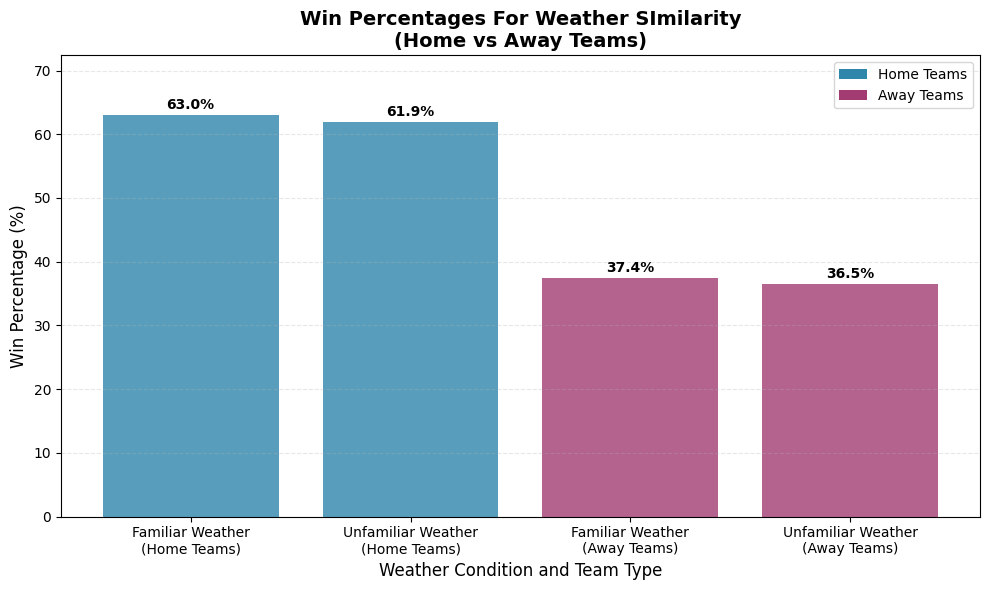

In [60]:
home_familiar_win_rate = home_team_familiar['score_home'].gt(home_team_familiar['score_away']).mean()
home_unfamiliar_win_rate = home_team_unfamiliar['score_home'].gt(home_team_unfamiliar['score_away']).mean()
away_familiar_win_rate = away_team_familiar['score_away'].gt(away_team_familiar['score_home']).mean()
away_unfamiliar_win_rate = away_team_unfamiliar['score_away'].gt(away_team_unfamiliar['score_home']).mean()

create_weather_win_visualization(
    home_familiar_win_rate, home_unfamiliar_win_rate,
    away_familiar_win_rate, away_unfamiliar_win_rate
)